In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

# modulation scheme and constellation points for bpsk
M = 16
qam = [ ((2*(m+1)-np.sqrt(M)-1) + 1j*(2*(n+1)-np.sqrt(M)-1)) for n in range(int(np.sqrt(M))) for m in range(int(np.sqrt(M))) ]
modulation = {f"{i:04b}": symb for (i, symb) in zip(range(M), qam)}
n_symbol = 1000 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

In [3]:
## Global Transmission parameters
z_length = 70  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [4]:
# simulate channel for multiple power inputs
sims ={}
for power in np.arange(-5,10):
    send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, n_symbol, power)
    send = add_zeros(send_rc, 100 * int(1/f_symbol/t_sample_rc))

    ## Simulation of reference transmission (dz = 0.1 km)
    nz_ref = 100  # steps
    dz_ref = z_length / nz_ref  # [km]

    output_ref = splitstepfourier(send, t_sample_rc, dz_ref, nz_ref, alpha, beta2, gamma)

    d_nz = 1 # d_nz to use in loop
    ## Simulation of fibers with different step sizes
    step_sweep_sim = []
    for nz in np.arange(1, nz_ref+d_nz, step=d_nz):
        dz = z_length / nz
        output = splitstepfourier(send, t_sample_rc, dz, nz, alpha, beta2, gamma)
        step_sweep_sim.append((nz, output))
    
    sims[f"{power}"] = (output_ref, step_sweep_sim)

Text(0.5, 0, 'Anzahl simulierter Schritte (nz)')

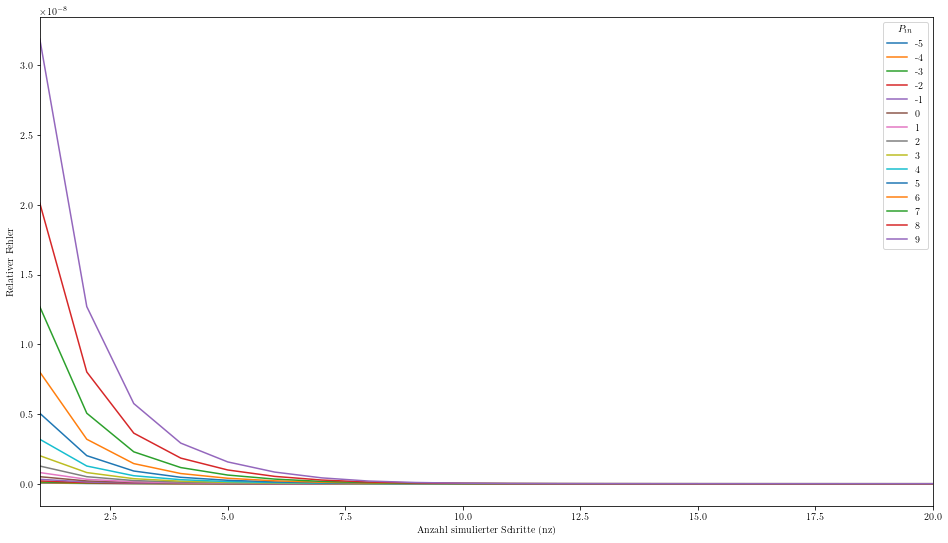

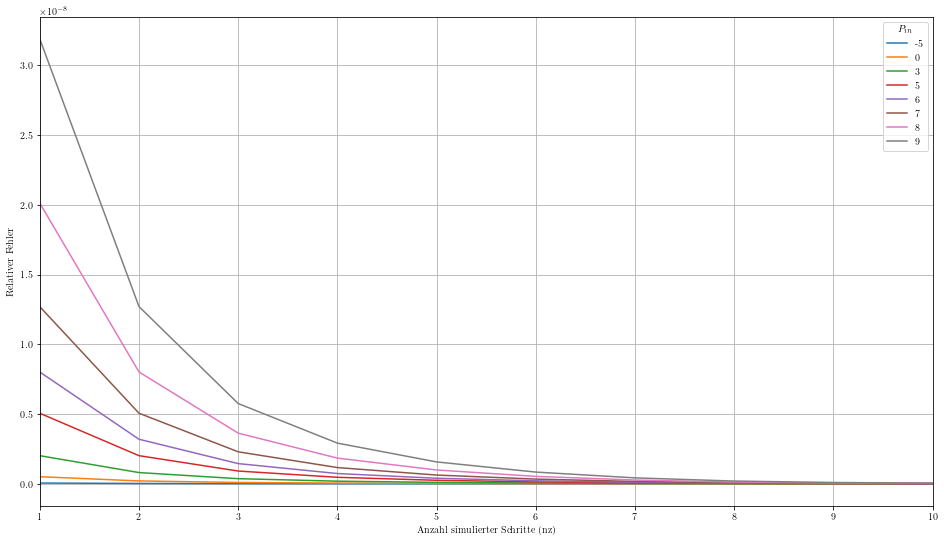

In [5]:
## Plots
fig1 = plt.figure(figsize=figure_size)
plot1 = fig1.add_subplot()
fig2 = plt.figure(figsize=figure_size)
plot2 = fig2.add_subplot()
for key, data in sims.items():
    ref = data[0]
    signal = data[1]
    x_vals = []
    y_vals = []
    for n_steps, sim_out in signal:
        x_vals.append(n_steps)
        y_vals.append(abs(calc_relerr(sim_out, ref)))

    plot1.plot(x_vals, y_vals, label=key)
    if key in ['-5', '0', '3', '5', '6', '7', '8', '9']:
        plot2.plot(x_vals, y_vals, label=key)

xmin = np.amin(x_vals)
xmax = np.amax(x_vals)

plot1.legend(loc='upper right', title='$P_{in}$')
plot1.set_xlim(xmin, 20)
plot1.set_ylabel("Relativer Fehler")
plot1.set_xlabel("Anzahl simulierter Schritte (nz)")

plot2.legend(loc='upper right', title='$P_{in}$')
plot2.grid()
plot2.set_xlim(xmin, 10)
plot2.set_ylabel("Relativer Fehler")
plot2.set_xlabel("Anzahl simulierter Schritte (nz)")

In [6]:
# simulate channel for multiple power inputs without alpha
sims2 ={}
for power in np.arange(-5,10):
    send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, n_symbol, power)
    send = add_zeros(send_rc, 100 * int(1/f_symbol/t_sample_rc))

    ## Simulation of reference transmission (dz = 0.1 km)
    nz_ref = 100  # steps
    dz_ref = z_length / nz_ref  # [km]

    output_ref = splitstepfourier(send, t_sample_rc, dz_ref, nz_ref, 0, beta2, gamma)

    d_nz = 1 # d_nz to use in loop
    ## Simulation of fibers with different step sizes
    step_sweep_sim = []
    for nz in np.arange(1, nz_ref+d_nz, step=d_nz):
        dz = z_length / nz
        output = splitstepfourier(send, t_sample_rc, dz, nz, 0, beta2, gamma)
        step_sweep_sim.append((nz, output))
    
    sims2[f"{power}"] = (output_ref, step_sweep_sim)

Text(0.5, 0, 'Anzahl simulierter Schritte (nz)')

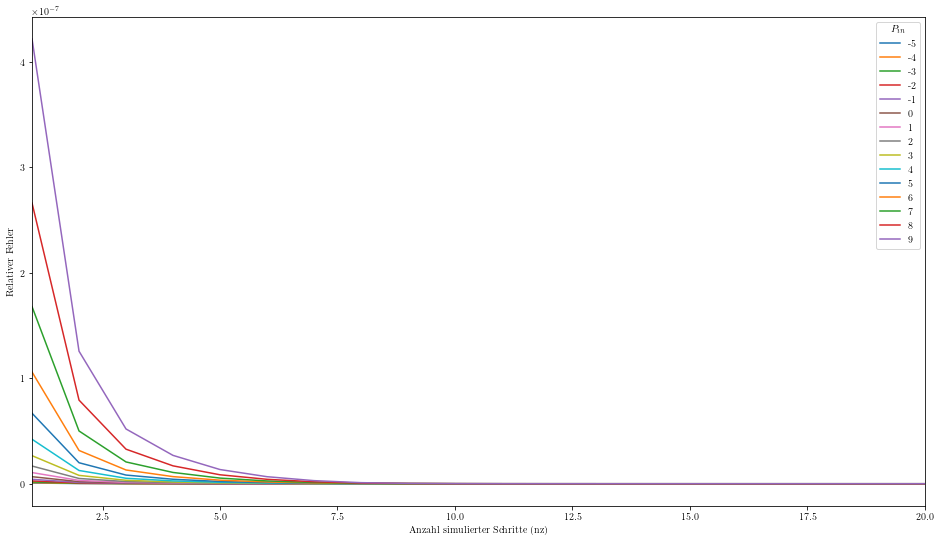

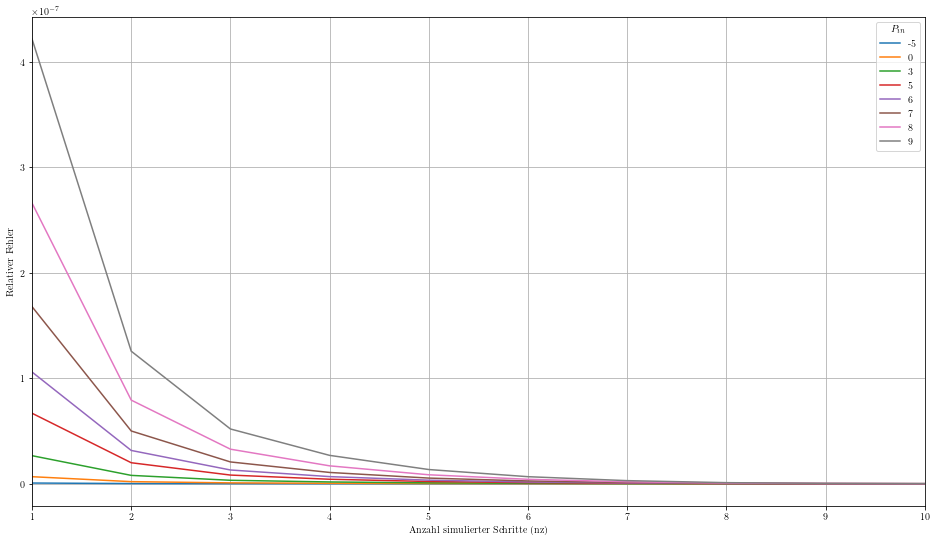

In [7]:
## Plots
fig3 = plt.figure(figsize=figure_size)
plot3 = fig3.add_subplot()
fig4 = plt.figure(figsize=figure_size)
plot4 = fig4.add_subplot()
for key, data in sims2.items():
    ref = data[0]
    signal = data[1]
    x_vals = []
    y_vals = []
    for n_steps, sim_out in signal:
        x_vals.append(n_steps)
        y_vals.append(abs(calc_relerr(sim_out, ref)))

    plot3.plot(x_vals, y_vals, label=key)
    if key in ['-5', '0', '3', '5', '6', '7', '8', '9']:
        plot4.plot(x_vals, y_vals, label=key)

xmin = np.amin(x_vals)
xmax = np.amax(x_vals)

plot3.legend(loc='upper right', title='$P_{in}$')
plot3.set_xlim(xmin, 20)
plot3.set_ylabel("Relativer Fehler")
plot3.set_xlabel("Anzahl simulierter Schritte (nz)")

plot4.legend(loc='upper right', title='$P_{in}$')
plot4.grid()
plot4.set_xlim(xmin, 10)
plot4.set_ylabel("Relativer Fehler")
plot4.set_xlabel("Anzahl simulierter Schritte (nz)")

In [8]:
output_fname = "steps_sweep_16qam"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}_full.tex', figure=fig1, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_zoom.tex', figure=fig2, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_full_noalpha.tex', figure=fig3, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_zoom_noalpha.tex', figure=fig4, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)

fig1.savefig(f"{output_path}{output_fname}_full.pdf", bbox_inches='tight')
fig2.savefig(f"{output_path}{output_fname}_zoom.pdf", bbox_inches='tight')
fig3.savefig(f"{output_path}{output_fname}_full_noalpha.pdf", bbox_inches='tight')
fig4.savefig(f"{output_path}{output_fname}_zoom_noalpha.pdf", bbox_inches='tight')